Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed


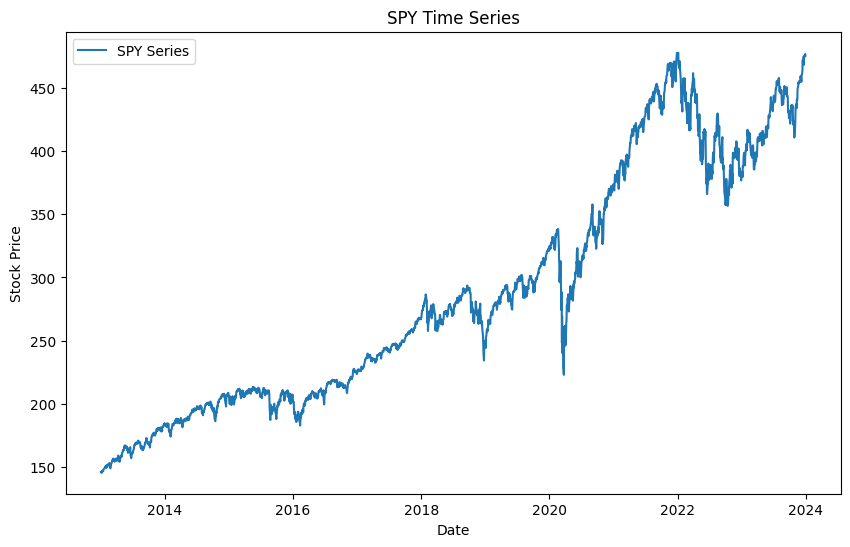

In [11]:
%pip install -r requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Step 1: Load Data
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

ticker = 'SPY'
start_date = "2013-01-01"
end_date = "2024-01-01"
data = load_data(ticker, start_date, end_date)

# Plot the original series
plt.figure(figsize=(10, 6))
plt.plot(data, label=f"{ticker} Series")
plt.title(f"{ticker} Time Series")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

ADF Statistic: -0.3948627922860241
p-value: 0.9109529801231568
ADF Statistic: -16.421135239416085
p-value: 2.529768570741418e-29
Differencing order: 1, Stationary: True


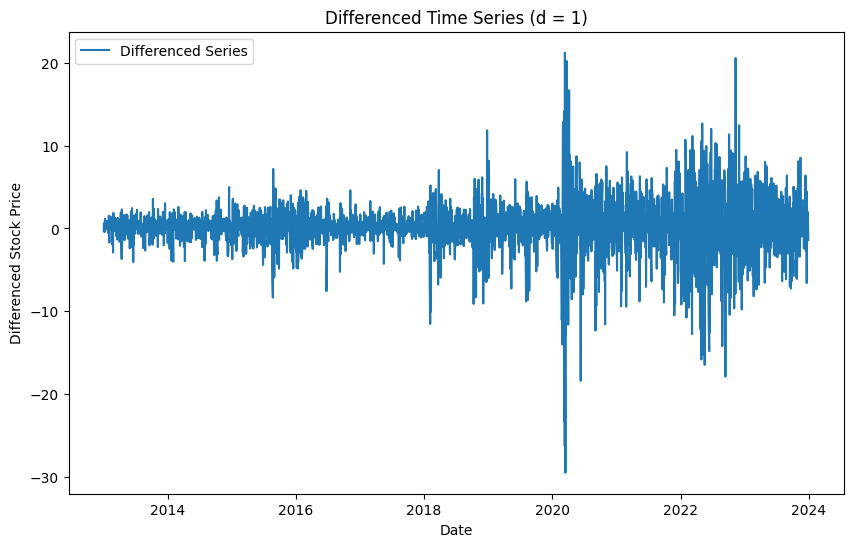

In [12]:
# Step 2: Check for Stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] < 0.05

# Step 3: Apply Differencing
def difference_series(series, order=1):
    return series.diff(order).dropna()

# Determine optimal d
def determine_d(series, max_d=5):
    d = 0
    stationary = check_stationarity(series)
    while not stationary and d < max_d:
        d += 1
        series = difference_series(series, d)
        stationary = check_stationarity(series)
        print(f'Differencing order: {d}, Stationary: {stationary}')
    return d, series

# Determine the optimal d value
d, differenced_data = determine_d(data)

# Plot differenced series
plt.figure(figsize=(10, 6))
plt.plot(differenced_data, label='Differenced Series')
plt.title(f'Differenced Time Series (d = {d})')
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.legend()
plt.show()


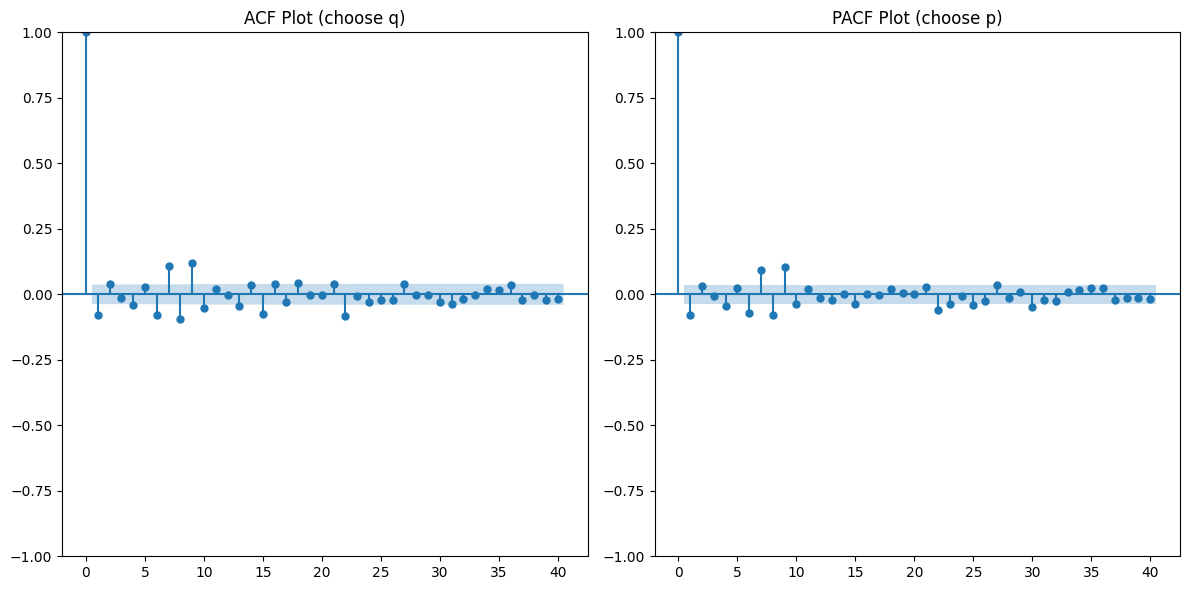

In [20]:

# Plot ACF and PACF
def plot_acf_pacf(series, lags):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('ACF Plot (choose q)')

    plt.subplot(1, 2, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('PACF Plot (choose p)')

    plt.tight_layout()
    plt.show()

# Step 4: Automate q detection
def determine_q(series, nlags=40):
    acf_vals = acf(series, nlags=nlags)
    q = next((i for i, val in enumerate(acf_vals) if abs(val) < 1.96 / np.sqrt(len(series))), None)
    return q

# Plot ACF and PACF using the determined d value for lags
plot_acf_pacf(differenced_data, 40)

# Identify the optimal q value
q = determine_q(differenced_data)

# Step 5: Automate p detection
def determine_p(series, nlags=40):
    pacf_vals = pacf(series, nlags=nlags)
    p = next((i for i, val in enumerate(pacf_vals) if abs(val) < 1.96 / np.sqrt(len(series))), None)
    return p

p = determine_p(differenced_data)

In [14]:
print(f'Optimal d value: {d}')

print(f'Optimal q value: {q}')

print(f'Optimal p value: {p}')

Optimal d value: 1
Optimal q value: 3
Optimal p value: 2


In [15]:
prices = data
# Preprocessing
prices = prices.tz_localize(None)
prices.index = pd.DatetimeIndex(prices.index).to_period(freq='B')

/var/folders/rc/1gncypfj79z_ctr__cysx0hr0000gn/T/ipykernel_60719/2260222969.py:4: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  prices.index = pd.DatetimeIndex(prices.index).to_period(freq='B')


In [16]:
# Split the data into training and testing sets
train_end_date = prices.index[-31]  # Use all but the last 30 data points for training
train_data = prices[:train_end_date]
test_data = prices[train_end_date:]

In [17]:
# Step 6: Automatizing ARIMA
model_auto = auto_arima(train_data, 
                   start_p=1, start_q=1,
                   max_p=5, max_q=5,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14362.212, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14377.687, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14362.575, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14363.710, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14378.699, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14363.427, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14363.210, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14361.652, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14362.288, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14362.732, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14362.909, Time=0.15 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.764 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

In [18]:
# Step 7: Forecasting
forecast, conf_int = model_auto.predict(n_periods=len(test_data), return_conf_int=True)

/Users/borjaruizdelgadofernandez/Documents/GitHub/gists/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:140: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = index_fn(
/Users/borjaruizdelgadofernandez/Documents/GitHub/gists/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:140: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = index_fn(


/var/folders/rc/1gncypfj79z_ctr__cysx0hr0000gn/T/ipykernel_60719/761472887.py:6: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ax1.plot(train_data.index.to_timestamp(), train_data.values, label='Historical Data')
/var/folders/rc/1gncypfj79z_ctr__cysx0hr0000gn/T/ipykernel_60719/761472887.py:7: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ax1.plot(test_data.index.to_timestamp(), test_data.values, label='Actual Future Data', color='green')
/var/folders/rc/1gncypfj79z_ctr__cysx0hr0000gn/T/ipykernel_60719/761472887.py:8: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ax1.plot(test_data.index.to_timestamp(), forecast, color='red', label='Forecast')
/var/folders/rc/1gncypfj79z_ctr__cysx0hr0000gn/T/ipykernel_60719/761472887.py:9: FutureWarning: Peri

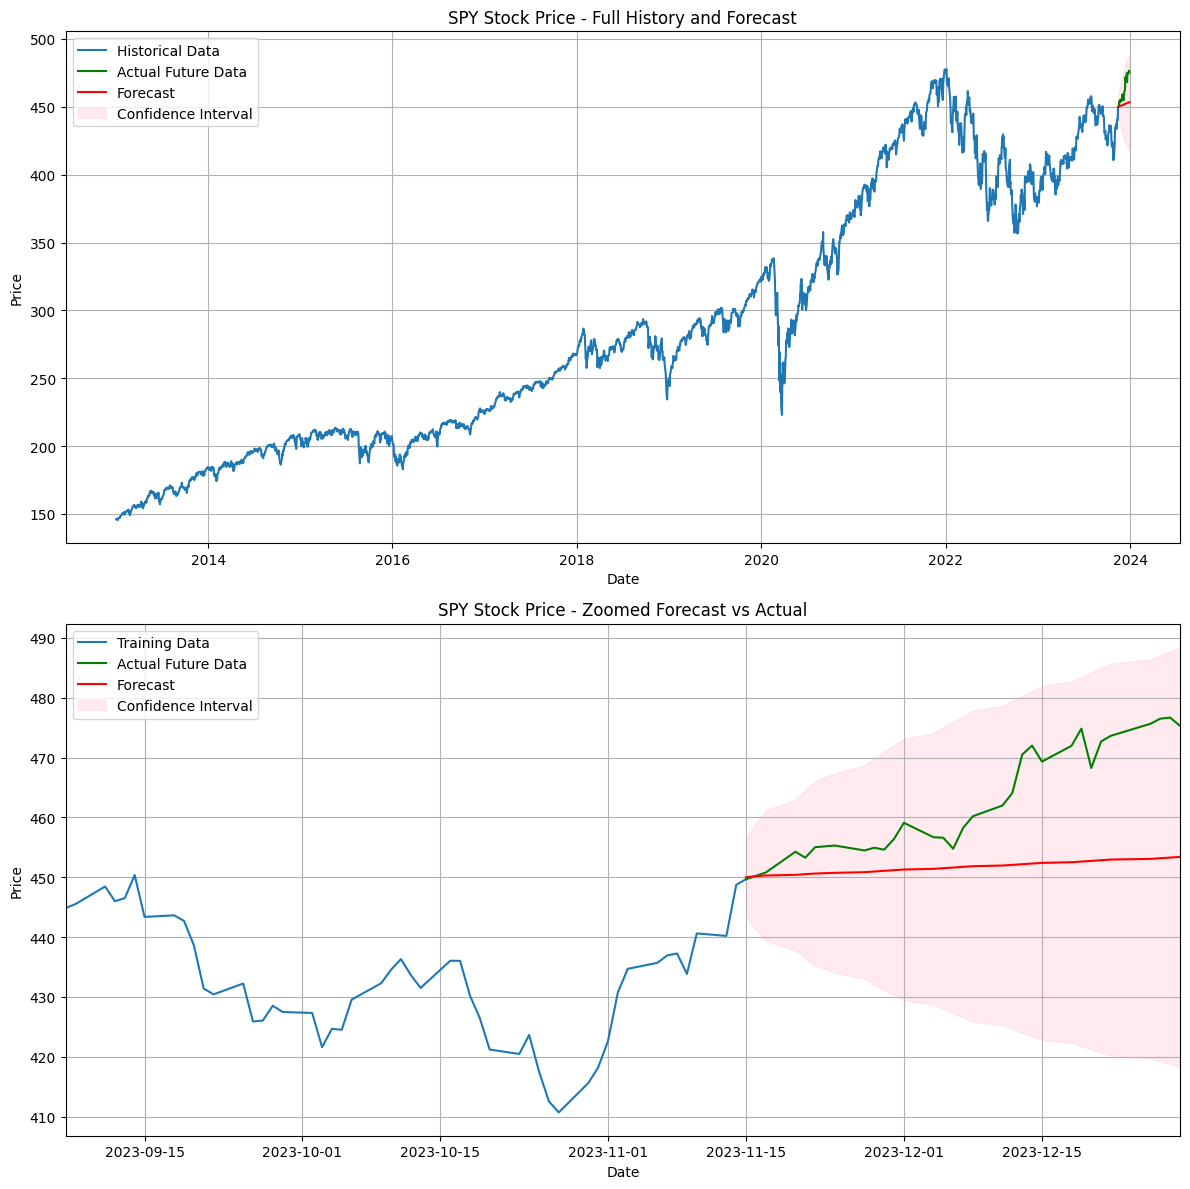

In [19]:
def plot_forecast_vs_actual(train_data, test_data, forecast, conf_int, ticker):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: All data
    ax1.plot(train_data.index.to_timestamp(), train_data.values, label='Historical Data')
    ax1.plot(test_data.index.to_timestamp(), test_data.values, label='Actual Future Data', color='green')
    ax1.plot(test_data.index.to_timestamp(), forecast, color='red', label='Forecast')
    ax1.fill_between(test_data.index.to_timestamp(), 
                     conf_int[:, 0], 
                     conf_int[:, 1], 
                     color='pink', alpha=0.3, label='Confidence Interval')
    ax1.set_title(f'{ticker} Stock Price - Full History and Forecast')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Zoomed in on prediction period
    zoom_start = train_data.index[-50]  # Start zoom 50 periods before test data
    ax2.plot(train_data.loc[zoom_start:].index.to_timestamp(), 
             train_data.loc[zoom_start:].values, label='Training Data')
    ax2.plot(test_data.index.to_timestamp(), test_data.values, label='Actual Future Data', color='green')
    ax2.plot(test_data.index.to_timestamp(), forecast, color='red', label='Forecast')
    ax2.fill_between(test_data.index.to_timestamp(), 
                     conf_int[:, 0], 
                     conf_int[:, 1], 
                     color='pink', alpha=0.3, label='Confidence Interval')
    ax2.set_title(f'{ticker} Stock Price - Zoomed Forecast vs Actual')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True)
    
    # Set x-axis limits for the zoomed plot
    ax2.set_xlim(zoom_start, test_data.index[-1])
    
    plt.tight_layout()
    plt.show()

# Step 8: Plot the forecast vs actual data
plot_forecast_vs_actual(train_data, test_data, forecast, conf_int, ticker)